## Notes

Anton använder geopy och smhi api. 

## Pre-Processing

In [ ]:
import geopandas as gpd
import pandas as pd
import geopy
from tqdm import tqdm
import time
from geopy.geocoders import Nominatim
import numpy as np
import holidays




dataset = pd.read_excel("/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/train_delay_data.xlsx")
dataset = dataset.drop(columns=['Unnamed: 0'], errors='ignore')

print(f'Shape before processing: {dataset.shape}')
# 2. Date
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Month'] = dataset['Date'].dt.month
dataset['Weekday'] = dataset['Date'].dt.weekday  
dataset['Holiday'] = dataset['Date'].apply(lambda x: x in holidays.Sweden())
# Seasons
def get_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

dataset['Season'] = dataset['Month'].apply(get_season)

# Remove missing values from specific columns
columns_to_check = [col for col in dataset.columns if col not in ['Reason code', 'Reason code Level 3','Route']]
mask = (dataset[columns_to_check] != "-") & (dataset[columns_to_check] != -1) & (dataset[columns_to_check] != None)
data_cleaned = dataset[mask.all(axis=1)].copy()
dataset = data_cleaned

city_mapping = {
    "LE": "Luleå",
    "UÅ": "Umeå",
    "KMB": "Kiruna",
    "SUC": "Skellefteå",
    "ÖK": "Örnsköldsvik",
    "LY": "Lycksele",
    "VNS": "Vännäs",
    "ÖS": "Östersund",
    "STR": "Stockholm",
    "LJUSDAL": "Ljusdal",
    "GÄVLE": "Gävle",
    "SUNDSVALL": "Sundsvall",
    "CG": "Charlottenberg",
    "KHN": "Kristinehamn",
    "TORSBY": "Torsby",
    "OSLO/KO": "Oslo",
    "KO/OSLO": "Oslo",
    "G": "Göteborg",
    "TJT": "Torneträsk",
    "BDN": "Boden",
    "BLG": "Borlänge",
    "MRA": "Mora",
    "HD": "Hudiksvall",
    "V": "Västervik",
    "N": "Norrköping",
}
city_latlong_lookup = {
    "Umeå": (63.8258, 20.2630),
    "Luleå": (65.5848, 22.1547),
    "Sundsvall": (62.3908, 17.3069),
    "Stockholm": (59.3293, 18.0686),
    "Göteborg": (57.7089, 11.9746),
    "Malmö": (55.6050, 13.0038),
    "Östersund": (63.1792, 14.6357),
    "Gävle": (60.6749, 17.1413),
    "Kiruna": (67.8558, 20.2251),
    "Boden": (65.8251, 21.6886),
    "Skellefteå": (64.7502, 20.9509),
    "Vännäs": (63.9023, 19.7522),
    "Rundvik": (63.6412, 19.2792),
    "Örnsköldsvik": (63.2909, 18.7153),
    "Storsund": (65.9667, 21.0667),
    "Gimonäs": (63.8261, 20.3346),
    "Kirunavaara": (67.8667, 20.1833),
    'Mora': (60.00972, 14.56361),
    "Charlottenberg": (59.5667, 12.4167),
    "Oslo": (59.9139, 10.7522)
}

# Seperate the route into 'From' and 'To' columns
def separate_and_translate(route):
    cities = route.split('-')
    if len(cities) == 2:
        return city_mapping.get(cities[0], cities[0]), city_mapping.get(cities[1], cities[1])
    elif len(cities) > 2:
        return city_mapping.get(cities[0], cities[0]), city_mapping.get(cities[-1], cities[-1])
    else:
        return city_mapping.get(route, route), None
    
dataset[['From', 'To']] = dataset['Route'].apply(lambda x: pd.Series(separate_and_translate(x)))

# Delay labeling and categorization
def punctuality_label(delay):
    if delay <= 5:
        return 'Punctual'
    elif delay > 5 and delay < 20:
        return 'Delayed'
    elif delay >= 20 and delay < 40:
        return 'Very delayed'
    else:
        return 'Extremely delayed'
    
dataset['Punctuality'] = dataset['registered delay'].apply(punctuality_label)
# Separate datasets
normal_delays = dataset[dataset['Punctuality'] != 'Extremely delayed']
extreme_delays = dataset[dataset['Punctuality'] == 'Extremely delayed']

def get_coordinates(city):

    if city not in city_latlong_lookup:

        geolocator = Nominatim(user_agent="myGeocoder")

        try: 
            time.sleep(1)
            location = geolocator.geocode(city)
            latitude, longitude = location.latitude, location.longitude
            city_latlong_lookup.update({city: (latitude, longitude)})
            
            return (latitude, longitude)
        except:
            print(f"Could not find coordinates for {city}")
            return (None, None)
    else:
        (latitude, longitude) = city_latlong_lookup[city]
        return (latitude, longitude)
    
dataset['From_coordinates'] = dataset.apply(lambda row: get_coordinates(row['From']), axis=1)
dataset['To_coordinates'] = dataset.apply(lambda row: get_coordinates(row['To']), axis=1)
dataset['Tågnr'] = pd.to_numeric(dataset['Tågnr'], errors='coerce')
dataset['Route number'] = pd.to_numeric(dataset['Route number'], errors='coerce')


# Add haversine distance to dataset
def haversine_distance(city1, city2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1 = city1[0], city1[1]
    lat2, lon2 = city2[0], city2[1]
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2.0)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return int(round(distance))
# Calculate haversine distance for each row
dataset['Havestine Distance'] = dataset.apply(lambda row: haversine_distance(row['From_coordinates'],row['To_coordinates']), axis=1)

dataset.dropna()
# Save
dataset.to_json('dataset_saved.json', orient='records', indent=2)
print(f'Shape after processing: {dataset.shape}')


Shape before processing: (17834, 15)
Shape after processing: (16699, 25)


In [46]:
dataset = pd.read_json('dataset_saved.json', orient='records')
print(dataset.shape)

(16699, 25)


## Get datasets from SMHI api // Broken

Gets the datasets between 2018 and end of 2020 for each weather parameter.

In [ ]:
import requests
import os
import json
import pandas as pd
import numpy as np
import time
from datetime import datetime

# --- Settings ---

weather_parameters = {
    'Temperature': 1,        # Lufttemperatur
    'Snow_depth': 6,         # Snödjup
    'Max_wind_speed': 4,     # Maximal vindhastighet
    'Precipitation': 5       # Nederbördsmängd
}

start_date = datetime(2018, 1, 1)
end_date = datetime(2020, 10, 31)

output_folder = "station_weather_data"
os.makedirs(output_folder, exist_ok=True)

# --- Funktionen vi använder för avstånd ---

def haversine_distance(location1, location2):
    lat1, lon1 = location1
    lat2, lon2 = location2
    R = 6371  # Jordens radie i km

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

# --- Hitta närmaste fungerande station ---
def find_nearest_station(city_name, city_coords, stations_df):
    matches = stations_df[stations_df['name'].str.contains(city_name, case=False, na=False)]
    if not matches.empty:
        return matches.iloc[0]
    
    stations_df['distance'] = stations_df.apply(
        lambda row: haversine_distance(city_coords, (row['latitude'], row['longitude'])), axis=1
    )
    nearest_station = stations_df.loc[stations_df['distance'].idxmin()]
    return nearest_station

# --- Ladda och filtrera väderdata ---
def load_weather_data(station_id, param_id):
    url = f"https://opendata-download-metobs.smhi.se/api/version/1.0/parameter/{param_id}/station/{station_id}/period/corrected-archive/data.csv"
    response = requests.get(url)

    if response.status_code != 200:
        raise Exception(f"Fel vid hämtning för station {station_id} parameter {param_id}")
    
    lines = response.text.splitlines()
    data_rows = []

    for line in lines:
        parts = line.split(';')
        if len(parts) != 4:
            continue  # hoppa över konstiga rader

        date_str, time_str, value_str, quality = parts
        try:
            dt = datetime.strptime(date_str + " " + time_str, "%Y-%m-%d %H:%M:%S")
            if start_date <= dt <= end_date:
                value = float(value_str.replace(',', '.'))  # punkt som decimal
                data_rows.append({
                    'datetime': dt.strftime("%Y-%m-%d %H:%M:%S"),
                    'value': value,
                    'quality': quality
                })
        except:
            continue  # hoppa om formatet är skumt

    return data_rows

# --- Spara väderdata för alla städer ---
def save_station_data(cities_dict, stations_df):
    for city_name, city_coords in cities_dict.items():
        print(f"Behandlar stad {city_name}...")
        
        for feature_name, param_id in weather_parameters.items():
            tries = 0
            success = False
            current_stations = stations_df.copy()

            while tries < 5 and not success:
                try:
                    nearest_station = find_nearest_station(city_name, city_coords, current_stations)
                    station_id = nearest_station['id']
                    data_rows = load_weather_data(station_id, param_id)

                    if not data_rows:
                        print(f"  Ingen data i perioden för station {station_id}, provar nästa närmsta...")
                        # Ta bort denna station och prova nästa
                        current_stations = current_stations[current_stations['id'] != station_id]
                        tries += 1
                        continue

                    filename = f"{city_name.replace(' ', '_')}_{feature_name}.json"
                    filepath = os.path.join(output_folder, filename)

                    with open(filepath, 'w', encoding='utf-8') as f:
                        json.dump(data_rows, f, indent=2)

                    print(f"  Sparade {feature_name} till {filename}")
                    success = True

                except Exception as e:
                    print(f"  Fel vid hämtning för {city_name} - {feature_name}: {e}")
                    current_stations = current_stations[current_stations['id'] != station_id]
                    tries += 1
                    time.sleep(1)  # pausa kort mellan försök

            if not success:
                print(f"  Misslyckades med att hämta {feature_name} för {city_name} efter {tries} försök.")

# --- Börja köra allt ---

# Hämta stationsdata från SMHI
url = "https://opendata-download-metobs.smhi.se/api/version/1.0/parameter/1.json"
response = requests.get(url)
stations_df = pd.DataFrame(response.json().get('station', []))


save_station_data(city_latlong_lookup, stations_df)


Behandlar stad Umeå...
  Ingen data i perioden för station 140500, provar nästa närmsta...
  Ingen data i perioden för station 11, provar nästa närmsta...
  Sparade Temperature till Umeå_Temperature.json
  Ingen data i perioden för station 140500, provar nästa närmsta...
  Fel vid hämtning för Umeå - Snow_depth: Fel vid hämtning för station 11 parameter 6
  Sparade Snow_depth till Umeå_Snow_depth.json
  Ingen data i perioden för station 140500, provar nästa närmsta...
  Fel vid hämtning för Umeå - Max_wind_speed: Fel vid hämtning för station 11 parameter 4
  Sparade Max_wind_speed till Umeå_Max_wind_speed.json
  Ingen data i perioden för station 140500, provar nästa närmsta...
  Fel vid hämtning för Umeå - Precipitation: Fel vid hämtning för station 11 parameter 5
  Ingen data i perioden för station 140480, provar nästa närmsta...
  Ingen data i perioden för station 140490, provar nästa närmsta...
  Ingen data i perioden för station 139540, provar nästa närmsta...
  Misslyckades med at

In [ ]:
dataset = pd.read_json('dataset_saved.json', orient='records')


<class 'pandas.core.frame.DataFrame'>


In [ ]:
import os
import json
from collections import defaultdict

# Mapp där väderfiler ligger
weather_folder = "station_weather_data"

# Skapa en nested dictionary: weather_lookup[stad][parameter][datum] = värde
weather_lookup = defaultdict(lambda: defaultdict(dict))

# Läs in alla väderdatafiler
for filename in os.listdir(weather_folder):
    if filename.endswith(".json"):
        filepath = os.path.join(weather_folder, filename)
        
        parts = filename.replace(".json", "").split("_")
        city = parts[0]  # ex: "Umeå"
        feature = "_".join(parts[1:])  # ex: "Temperature", "Snow_depth", osv
        
        with open(filepath, 'r', encoding='utf-8') as f:
            dataset = json.load(f)

        for entry in dataset:
            date = entry['datetime'].split(" ")[0]  # Ta bara datumdelen (YYYY-MM-DD)
            value = entry['value']
            weather_lookup[city][feature][date] = value
# Definiera nya kolumnnamn
weather_features = ["Temperature", "Windspeed", "Snow_depth"]


for feature in weather_features:
    dataset[f"From_{feature}"] = None
    dataset[f"To_{feature}"] = None

for idx, row in tqdm(dataset.iterrows(), total=len(dataset)):

    date = row['Date'].strftime("%Y-%m-%d")  # Format: YYYY-MM-DD
    from_city = row['From']
    to_city = row['To']

    for feature in weather_features:
        # Hämta från From-stadens väder
        from_value = weather_lookup.get(from_city, {}).get(feature, {}).get(date, None)
        dataset.at[idx, f"From_{feature}"] = from_value

        # Hämta från To-stadens väder
        to_value = weather_lookup.get(to_city, {}).get(feature, {}).get(date, None)
        dataset.at[idx, f"To_{feature}"] = to_value


100%|██████████| 16699/16699 [00:03<00:00, 4569.09it/s]


In [ ]:
print(dataset.columns)
dataset.drop()


Index(['Train ID', 'Year', 'Date', 'Operator', 'Place', 'Train mission',
       'Tågnr', 'Route', 'Route number', 'Reason code',
       'Reason code - level 1', 'Reason code Level 2', 'Reason code Level 3',
       'registered delay', 'Vehicle number', 'Month', 'Weekday', 'Season',
       'From', 'To', 'Punctuality', 'From_coordinates', 'To_coordinates',
       'From_Temperature', 'To_Temperature', 'From_Windspeed', 'To_Windspeed',
       'From_Snow_depth', 'To_Snow_depth'],
      dtype='object')


,Train ID,Year,Date,Operator,Place,Train mission,Tågnr,Route,Route number,Reason code,...,To,Punctuality,From_coordinates,To_coordinates,From_Temperature,To_Temperature,From_Windspeed,To_Windspeed,From_Snow_depth,To_Snow_depth


## Select Columns

In [68]:
dataset = pd.read_json('dataset_saved.json', orient='records')

selected_columns = ['Route number',
                    'From',
                    'From_coordinates',
                    'To',
                    'To_coordinates',
                    'Tågnr', 'Reason code - level 1',
                    'Reason code Level 2',
                    'Reason code Level 3',
                    'registered delay',
                    'Season',
                    'Havestine Distance',
                    'Holiday',
                    'Punctuality']

dataset = dataset[selected_columns].copy()
dataset['Reason code Level 3'].replace(["-", "", -1], None, inplace=True)
dataset.to_json('dataset_saved_NoneReason3_pruned.json', orient='records', indent=2)
dataset = dataset.dropna()
dataset.to_json('dataset_saved_reason3_pruned.json', orient='records', indent=2)

/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/2957578510.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Reason code Level 3'].replace(["-", "", -1], None, inplace=True)


## Visualization


### Initial visualization


/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/2692745895.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


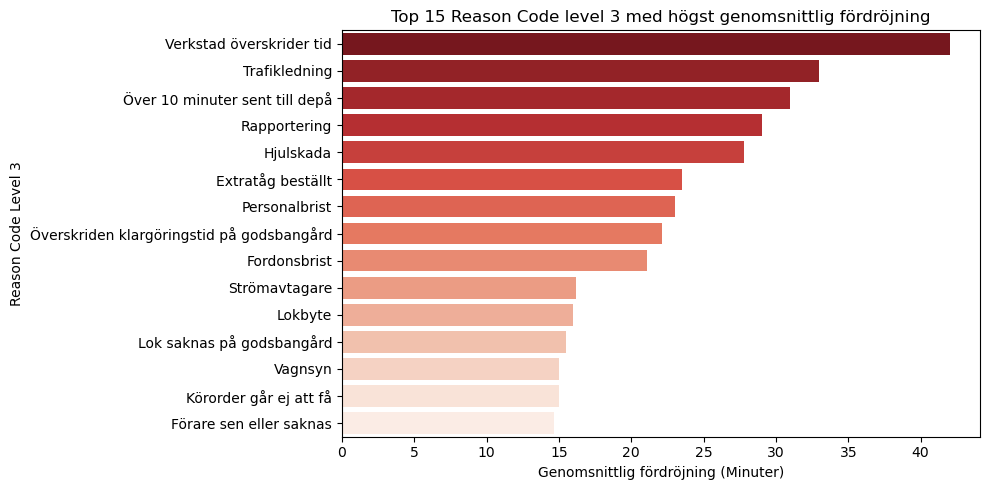

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_excel('/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/train_delay_data.xlsx')

# Group by "Reason code Level 3" and calculate the average delay
avg_delay_by_reason = (
    dataset.groupby("Reason code Level 3")["registered delay"]
    .mean()
    .sort_values(ascending=False)
    .dropna()
)

# Select the top 7 reasons with the highest average delay
top10_reasons = avg_delay_by_reason.head(15)

# Plot the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(
    x=top10_reasons.values,
    y=top10_reasons.index,
    palette="Reds_r"
)
plt.xlabel("Genomsnittlig fördröjning (Minuter)")
plt.ylabel("Reason Code Level 3")
plt.title("Top 15 Reason Code level 3 med högst genomsnittlig fördröjning")
plt.tight_layout()
plt.show()


/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/170219199.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


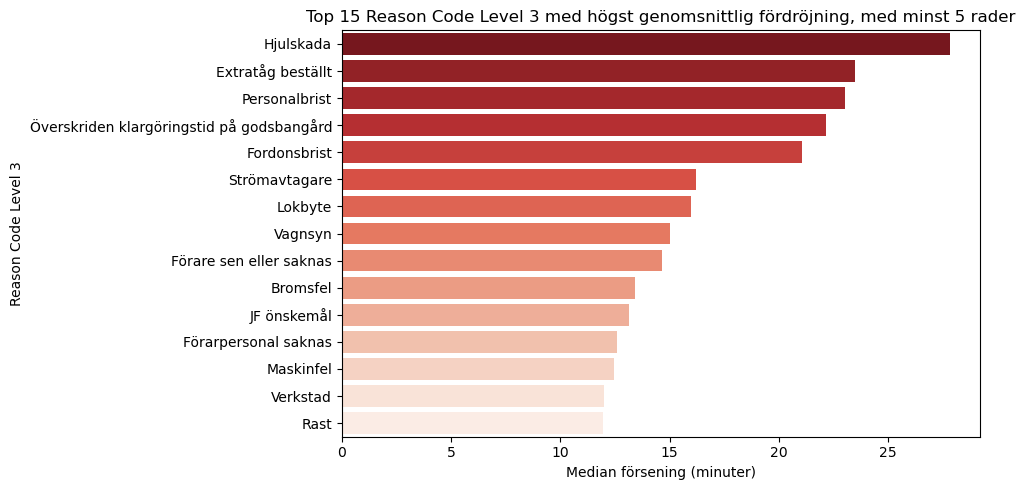

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ladda datan
dataset = pd.read_excel('/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/train_delay_data.xlsx')

# Filtrera bort kategorier med färre än 5 rader
valid_reasons = dataset["Reason code Level 3"].value_counts()
valid_reasons = valid_reasons[valid_reasons >= 5].index
filtered_dataset = dataset[dataset["Reason code Level 3"].isin(valid_reasons)]

# Beräkna medianfördröjning per orsak
avg_delay_by_reason = (
    filtered_dataset.groupby("Reason code Level 3")["registered delay"]
    .mean()
    .sort_values(ascending=False)
    .dropna()
)

# Ta ut de 15 med högst medianförsening
top15_reasons = avg_delay_by_reason.head(15)


plt.figure(figsize=(10, 5))
sns.barplot(
    x=top15_reasons.values,
    y=top15_reasons.index,
    palette="Reds_r"
)
plt.xlabel("Median försening (minuter)")
plt.ylabel("Reason Code Level 3")
plt.title("Top 15 Reason Code Level 3 med högst genomsnittlig fördröjning, med minst 5 rader")
plt.tight_layout()
plt.show()

In [77]:
# Räkna antal förekomster per orsak
counts = filtered_dataset["Reason code Level 3"].value_counts().reindex(top15_reasons.index)

# Visa som tabell
print(counts.sort_values(ascending=False))

Reason code Level 3
JF önskemål                                  2656
Maskinfel                                     694
Bromsfel                                      258
Förarpersonal saknas                          175
Strömavtagare                                  79
Rast                                           77
Lokbyte                                        51
Fordonsbrist                                   50
Hjulskada                                      42
Vagnsyn                                        31
Förare sen eller saknas                        31
Överskriden klargöringstid på godsbangård      13
Personalbrist                                   9
Extratåg beställt                               6
Verkstad                                        6
Name: count, dtype: int64


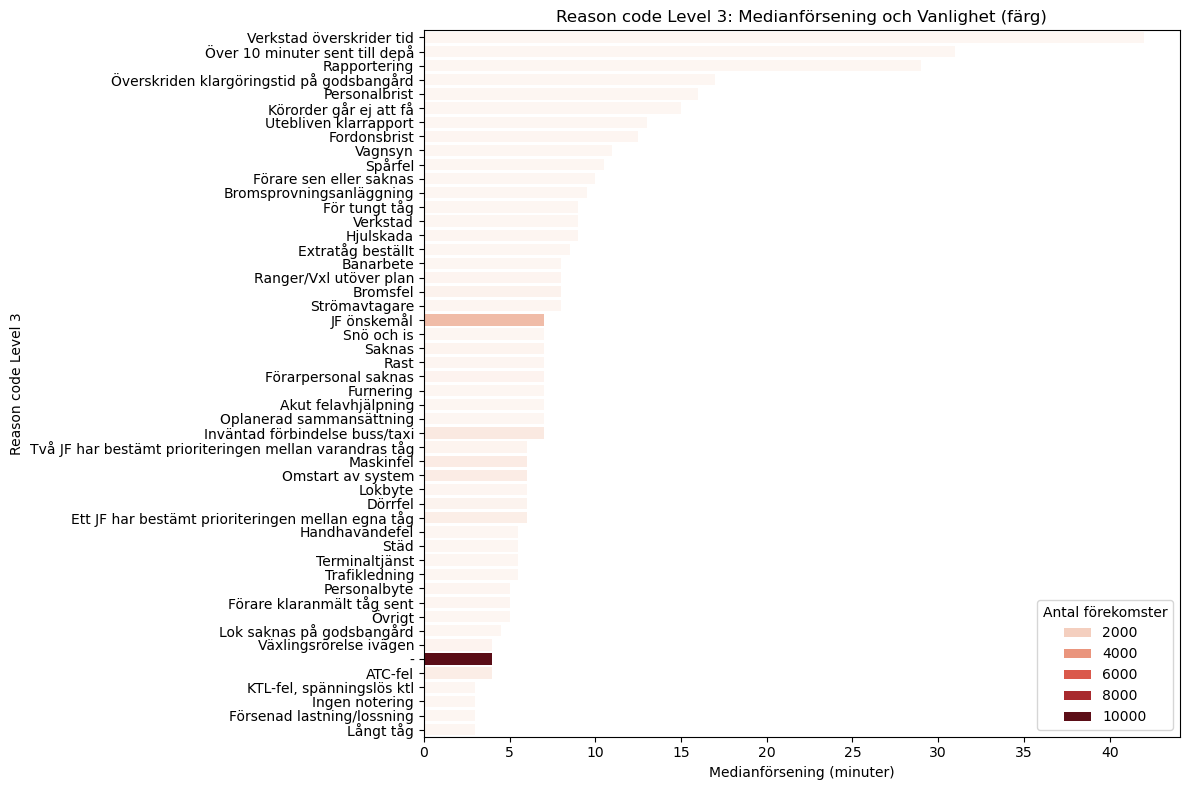

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/train_delay_data.xlsx')

# Grupp: medianförsening och antal händelser per Reason code Level 3
reason_stats = df.groupby("Reason code Level 3").agg(
    avg_delay=("registered delay", "median"),
    count=("registered delay", "count")
).sort_values(by="avg_delay", ascending=False)

# Plotta
plt.figure(figsize=(12, 8))
bar = sns.barplot(
    data=reason_stats.reset_index(),
    x="avg_delay",
    y="Reason code Level 3",
    hue="count",
    dodge=False,
    palette="Reds"
)

plt.xlabel("Medianförsening (minuter)")
plt.ylabel("Reason code Level 3")
plt.title("Reason code Level 3: Medianförsening och Vanlighet (färg)")
plt.legend(title="Antal förekomster", loc="lower right")
plt.tight_layout()
plt.show()


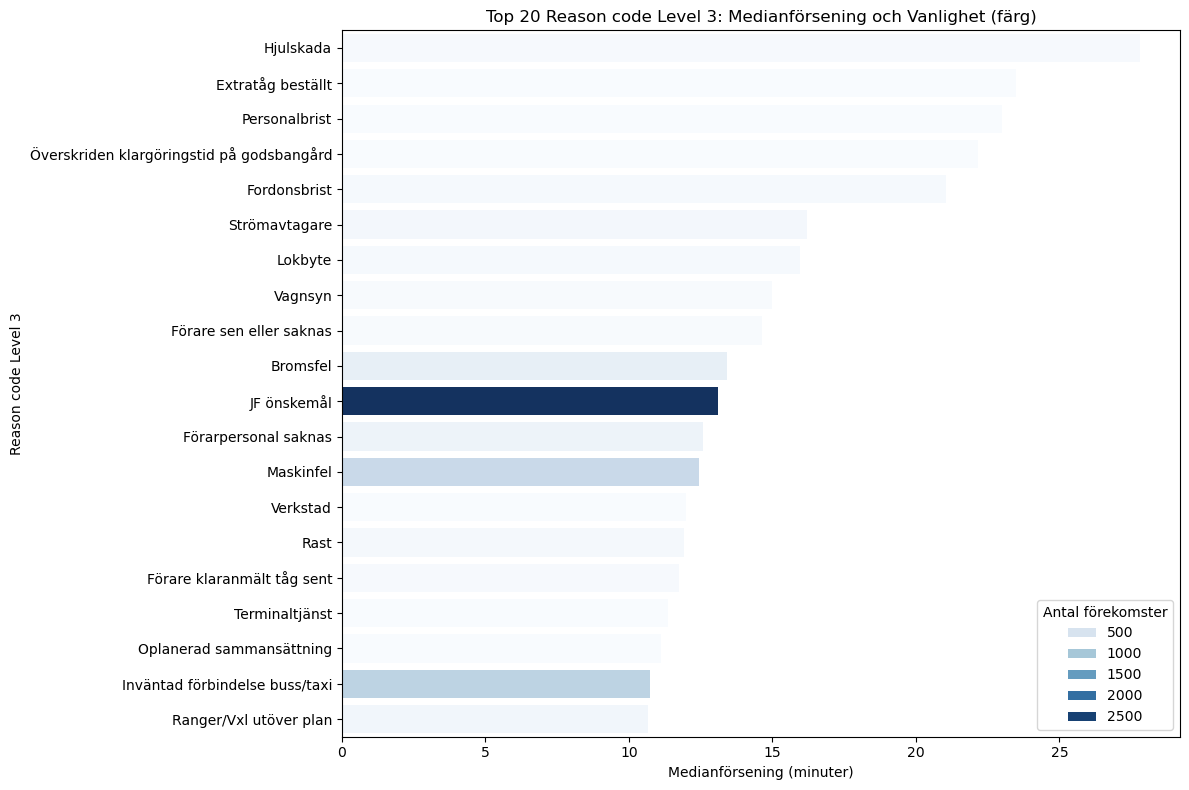

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Ladda datasetet igen
df = pd.read_excel('/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/train_delay_data.xlsx')


# Filtrera till Reason code Level 3 med minst 5 observationer
valid_reasons = df["Reason code Level 3"].value_counts()
valid_reasons = valid_reasons[valid_reasons >= 5].index
filtered_df = df[df["Reason code Level 3"].isin(valid_reasons)]

# Grupp: medianförsening och antal händelser per Reason code Level 3
reason_stats = filtered_df.groupby("Reason code Level 3").agg(
    avg_delay=("registered delay", "mean"),
    count=("registered delay", "count")
)

# Välj de 20 värsta baserat på högst medianförsening
top20_reasons = reason_stats.sort_values(by="avg_delay", ascending=False).head(20)

# --- 1. Stapeldiagram där färg representerar antal händelser ---
plt.figure(figsize=(12, 8))
bar = sns.barplot(
    data=top20_reasons.reset_index(),
    x="avg_delay",
    y="Reason code Level 3",
    hue="count",
    dodge=False,
    palette="Blues"
)
plt.xlabel("Medianförsening (minuter)")
plt.ylabel("Reason code Level 3")
plt.title("Top 20 Reason code Level 3: Medianförsening och Vanlighet (färg)")
plt.legend(title="Antal förekomster", loc="lower right")
plt.tight_layout()
plt.show()


### Distance vs mean delay

/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/1487633132.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delay_per_distance = df.groupby("distance_bin")["registered delay"].mean()


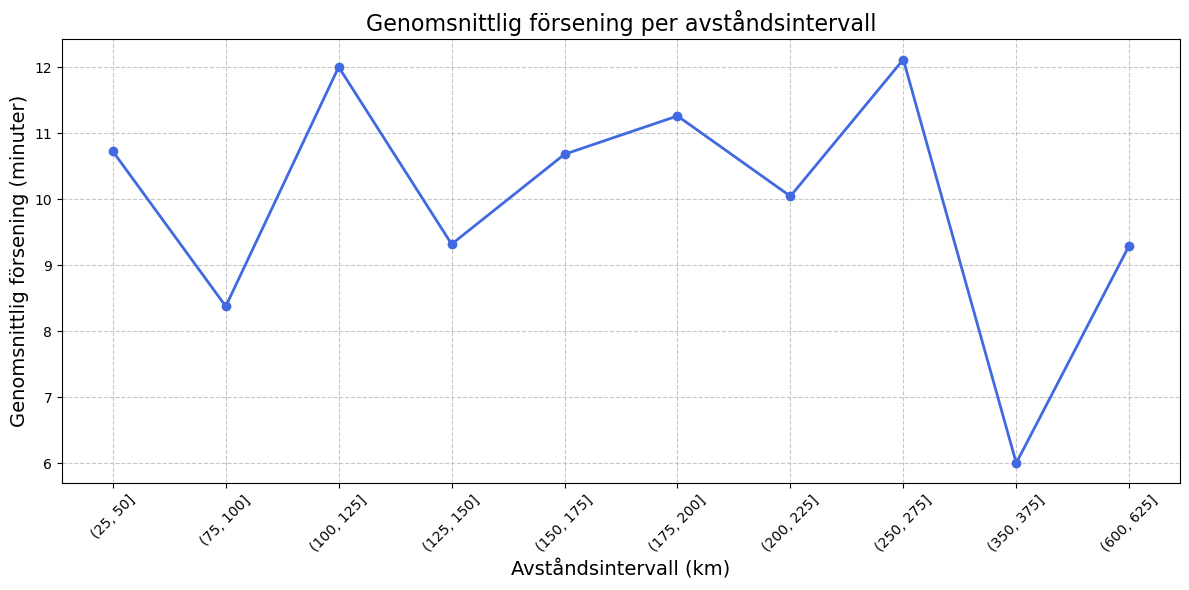

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_json('dataset_saved_reason3_pruned.json', orient='records')

# Om datan är från df
df["distance_bin"] = pd.cut(df["Havestine Distance"], bins=range(0, int(df["Havestine Distance"].max()) + 25, 25))

# Gruppera och räkna medelvärde
avg_delay_per_distance = df.groupby("distance_bin")["registered delay"].mean()

# Rensa NaNs
avg_delay_per_distance = avg_delay_per_distance.dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(
    avg_delay_per_distance.index.astype(str),
    avg_delay_per_distance.values,
    marker='o',
    linestyle='-',
    color='royalblue',
    linewidth=2,
    markersize=6
)

plt.title("Genomsnittlig försening per avståndsintervall", fontsize=16)
plt.xlabel("Avståndsintervall (km)", fontsize=14)
plt.ylabel("Genomsnittlig försening (minuter)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [71]:
# Skapa symmetriska rutter
df = pd.read_json('/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/dataset_saved_reason3_pruned.json', orient='records')
df["Symmetric_route"] = df.apply(
    lambda row: " ↔ ".join(sorted([row["From"], row["To"]])),
    axis=1
)

# Grupp: medelvärde av avstånd och försening per rutt
unique_routes = df.groupby("Symmetric_route")[["Havestine Distance", "registered delay"]].mean().reset_index()

# Sortera efter avstånd
sorted_routes = unique_routes.sort_values(by="Havestine Distance", ascending=True)

print(sorted_routes)


                  Symmetric_route  Havestine Distance  registered delay
12                  Umeå ↔ Vännäs                26.0         10.717241
0                   Boden ↔ Luleå                34.0         10.731959
1   Charlottenberg ↔ Kristinehamn               100.0          8.374798
11              Skellefteå ↔ Umeå               108.0         12.001709
9                 Lycksele ↔ Umeå               133.0          9.992840
6           KRISTINEHAMN ↔ Torsby               144.0          8.537190
2                 Gävle ↔ Ljusdal               153.0         10.679245
3               Gävle ↔ Sundsvall               191.0         11.259905
8                    Luleå ↔ Umeå               215.0         10.043071
4                 Göteborg ↔ Oslo               255.0          8.774194
7                  Kiruna ↔ Luleå               266.0         12.361474
5         Hudiksvall ↔ Norrköping               352.0          6.000000
10         Skellefteå ↔ Stockholm               621.0          9

### Level 3 vs mean delay

/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/2275012256.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


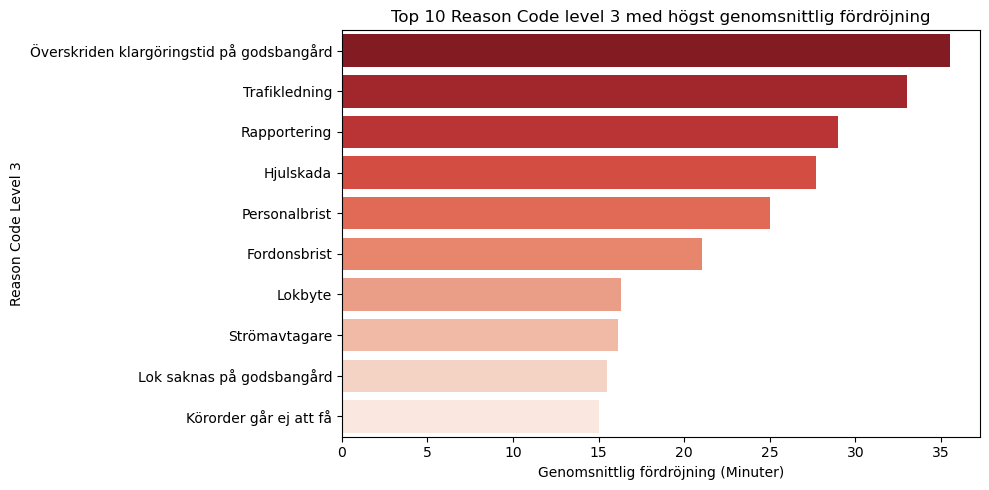

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_json('/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/dataset_saved_reason3_pruned.json', orient='records')

# Group by "Reason code Level 3" and calculate the average delay
avg_delay_by_reason = (
    dataset.groupby("Reason code Level 3")["registered delay"]
    .mean()
    .sort_values(ascending=False)
    .dropna()
)

# Select the top 7 reasons with the highest average delay
top10_reasons = avg_delay_by_reason.head(10)

# Plot the bar chart
plt.figure(figsize=(10, 5))
sns.barplot(
    x=top10_reasons.values,
    y=top10_reasons.index,
    palette="Reds_r"
)
plt.xlabel("Genomsnittlig fördröjning (Minuter)")
plt.ylabel("Reason Code Level 3")
plt.title("Top 10 Reason Code level 3 med högst genomsnittlig fördröjning")
plt.tight_layout()
plt.show()


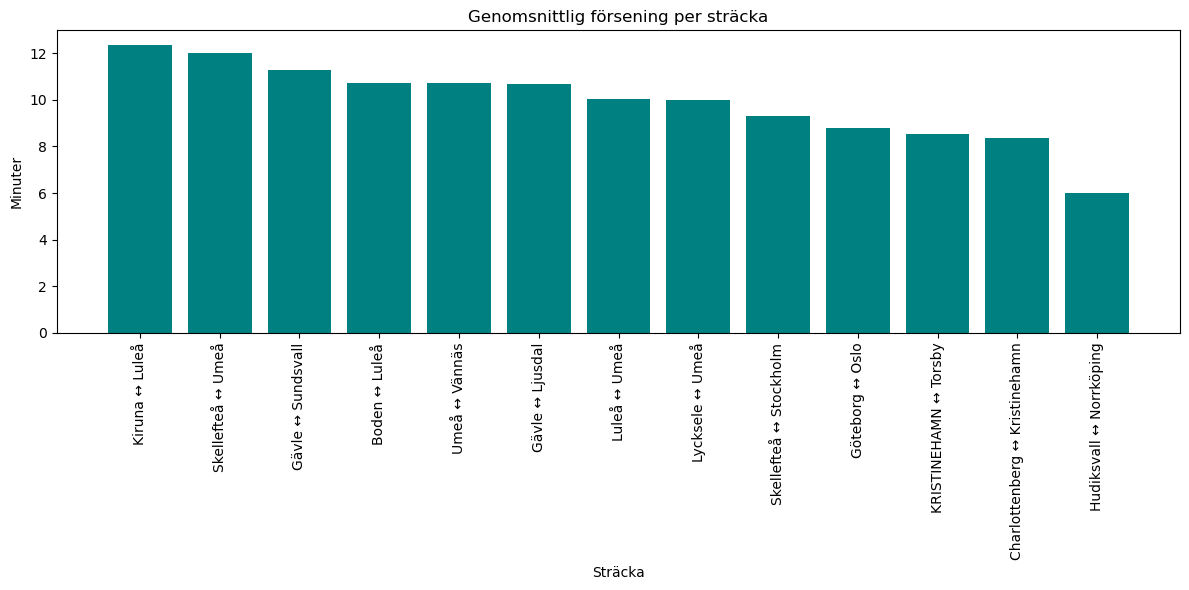

In [34]:
df = pd.read_json('/Users/ludvigflodin/Documents/Courses/D7018B/Assignment 3/dataset_saved_reason3_pruned.json', orient='records')

# Skapa ny kolumn för "symmetrisk rutt" - sortera From/To så att tur/retur behandlas som samma
df["Symmetric_route"] = df.apply(
    lambda row: " ↔ ".join(sorted([row["From"], row["To"]])),
    axis=1
)

# Grupp 1: Medelvärde per rutt (med outliers)
mean_delay = df.groupby("Symmetric_route")["registered delay"].mean().sort_values(ascending=False)

mean_delay_filtered_sorted = mean_delay.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mean_delay_filtered_sorted.index, mean_delay_filtered_sorted.values, color="teal")
plt.title("Genomsnittlig försening per sträcka")
plt.ylabel("Minuter")
plt.xlabel("Sträcka")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/1815243489.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


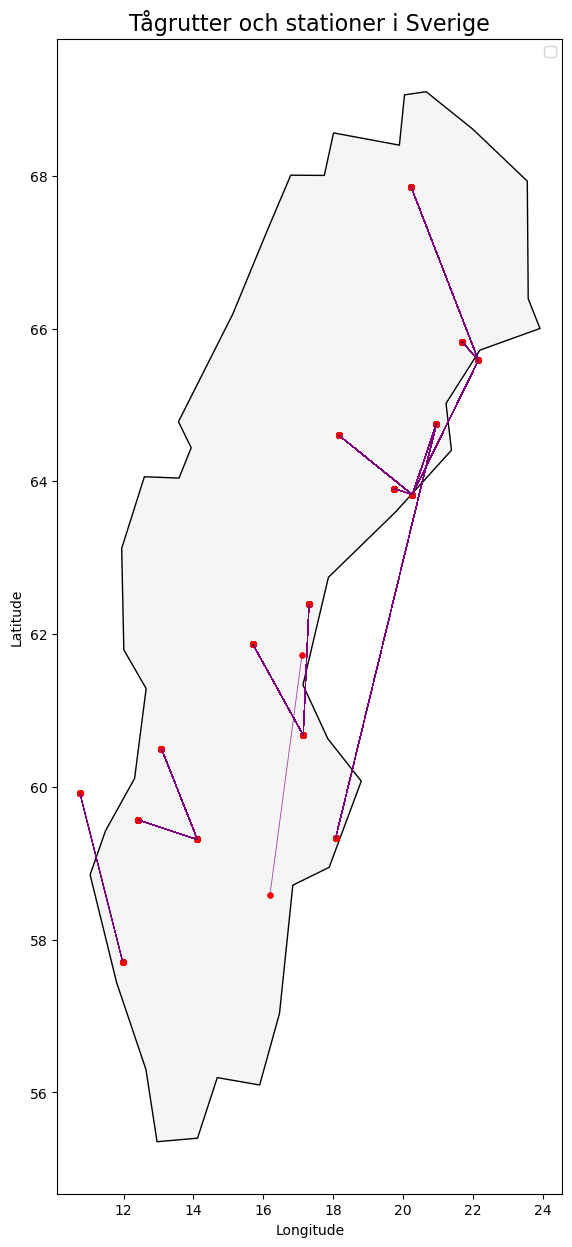

In [64]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import pandas as pd

# Om du inte redan gjort:
dataset = pd.read_json('dataset_saved_reason3_pruned.json', orient='records')

# 1. Förbered koordinaterna
dataset['From_coordinates'] = dataset['From_coordinates'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
dataset['To_coordinates'] = dataset['To_coordinates'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# 2. Skapa geometri för From- och To-stationerna
dataset['From_point'] = dataset['From_coordinates'].apply(lambda coord: Point(coord[1], coord[0]))  # (lon, lat)
dataset['To_point'] = dataset['To_coordinates'].apply(lambda coord: Point(coord[1], coord[0]))

# 3. Skapa GeoDataFrames
from_gdf = gpd.GeoDataFrame(dataset, geometry='From_point', crs="EPSG:4326")
to_gdf = gpd.GeoDataFrame(dataset, geometry='To_point', crs="EPSG:4326")

# 4. Skapa ruttlinjer
dataset['Route_Line'] = dataset.apply(lambda row: LineString([
    (row['From_coordinates'][1], row['From_coordinates'][0]),
    (row['To_coordinates'][1], row['To_coordinates'][0])
]), axis=1)

routes_gdf = gpd.GeoDataFrame(dataset, geometry='Route_Line', crs="EPSG:4326")

# 5. Ladda Sveriges karta från online källa
world = gpd.read_file('https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson')
sweden = world[world['NAME'] == 'Sweden']

# 6. Plot karta
fig, ax = plt.subplots(figsize=(10, 15))
sweden.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot rutter
routes_gdf.plot(ax=ax, color='purple', linewidth=0.5, alpha=0.5)

# Plot From och To stationer
from_gdf.plot(ax=ax, color='red', markersize=12)
to_gdf.plot(ax=ax, color='red', markersize=12)

plt.legend()
plt.title("Tågrutter och stationer i Sverige", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



### Season

/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/3047768198.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


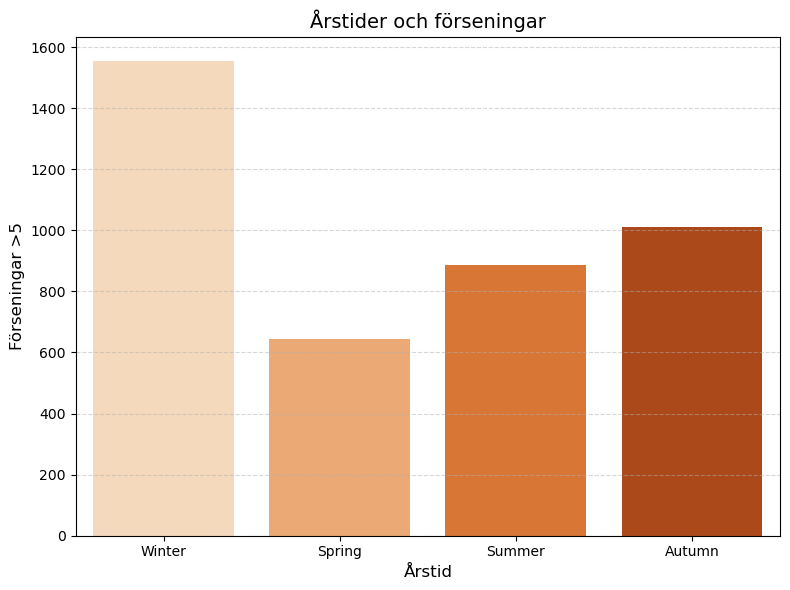

In [88]:
# Filtrera bort resor som är "Punctual"
df = pd.read_json('dataset_saved_reason3_pruned.json', orient='records')
non_punctual_df = df[df["Punctuality"] != "Punctual"]

# Beräkna antal resor per årstid för icke-punktliga tåg
season_stats_non_punctual = non_punctual_df["Season"].value_counts().reindex(["Winter", "Spring", "Summer", "Autumn"])

# Rita grafen
plt.figure(figsize=(8, 6))
sns.barplot(
    x=season_stats_non_punctual.index,
    y=season_stats_non_punctual.values,
    palette="Oranges"
)
plt.xlabel("Årstid", fontsize=12)
plt.ylabel("Förseningar >5", fontsize=12)
plt.title("Årstider och förseningar", fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




/var/folders/v6/pl0_dkns3pdd4gyq5whvz4nr0000gn/T/ipykernel_31661/4176892195.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


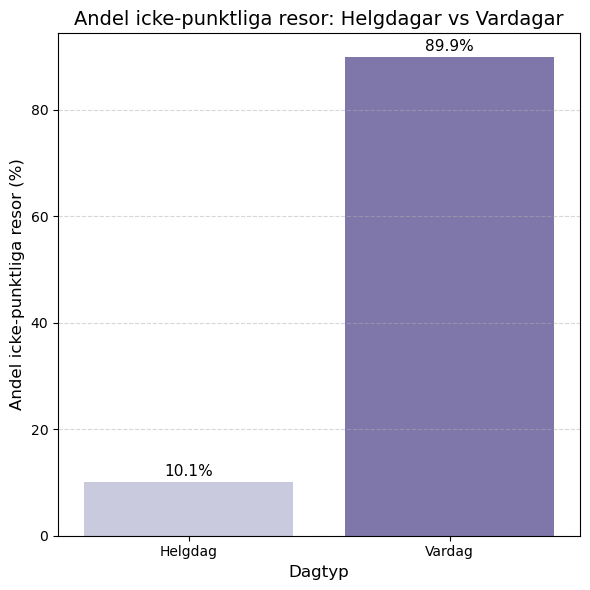

In [89]:
df = pd.read_json('dataset_saved_reason3_pruned.json', orient='records')
# Filtrera bort "Punctual" resor
non_punctual_df = df[df["Punctuality"] != "Punctual"]

# Beräkna antal icke-punktliga resor: Holiday (True/False)
holiday_stats_non_punctual = non_punctual_df["Holiday"].value_counts().reindex([True, False])
holiday_stats_normalized = holiday_stats_non_punctual / holiday_stats_non_punctual.sum() * 100
plt.figure(figsize=(6, 6))
ax = sns.barplot(
    x=holiday_stats_normalized.index.map({True: "Helgdag", False: "Vardag"}),
    y=holiday_stats_normalized.values,
    palette="Purples"
)
plt.xlabel("Dagtyp", fontsize=12)
plt.ylabel("Andel icke-punktliga resor (%)", fontsize=12)
plt.title("Andel icke-punktliga resor: Helgdagar vs Vardagar", fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Lägg till procenttal ovanpå staplarna
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=11, padding=2)

plt.tight_layout()
plt.show()


## Random forest

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

columns_to_encode = [
    'Reason code - level 1',
    'Reason code Level 2',
    'Reason code Level 3',
    'Season'
]

dataset = pd.read_json('dataset_saved_NoneReason3_pruned.json')
# dataset = pd.read_json('dataset_saved_reason3_pruned.json')
dataset = pd.get_dummies(dataset, columns=columns_to_encode, drop_first=True)
le = LabelEncoder()
dataset['Punctuality'] = le.fit_transform(dataset['Punctuality'])

# Split lat_Llong
dataset[['From_lat', 'From_lon']] = pd.DataFrame(dataset['From_coordinates'].tolist(), index=dataset.index)
dataset[['To_lat', 'To_lon']] = pd.DataFrame(dataset['To_coordinates'].tolist(), index=dataset.index)

# Drop columns
dataset = dataset.drop(columns=['From_coordinates', 'To_coordinates'])
dataset = dataset.drop(columns =['To','From'])
# Move labels to last column
punctuality_col = dataset.pop('Punctuality')
dataset['Punctuality'] = punctuality_col


Punctuality
2    10138
0     5060
3     1064
1      437
Name: count, dtype: int64

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd


columns_to_encode = [
    'Reason code - level 1',
    'Reason code Level 2',
    'Reason code Level 3',
    'Season'
]
dataset = pd.read_json('dataset_saved_NoneReason3_pruned.json')
dataset = pd.get_dummies(dataset, columns=columns_to_encode, drop_first=True)
le = LabelEncoder()
dataset['Punctuality'] = le.fit_transform(dataset['Punctuality'])

# Split lat_Llong
dataset[['From_lat', 'From_lon']] = pd.DataFrame(dataset['From_coordinates'].tolist(), index=dataset.index)
dataset[['To_lat', 'To_lon']] = pd.DataFrame(dataset['To_coordinates'].tolist(), index=dataset.index)

# Drop columns
dataset = dataset.drop(columns=['From_coordinates', 'To_coordinates'])
dataset = dataset.drop(columns =['To','From'])

# Move labels to last column
punctuality_col = dataset.pop('Punctuality')
dataset['Punctuality'] = punctuality_col
dataset

,Route number,Tågnr,Havestine Distance,Holiday,Reason code Level 2_Dragfordon / motorvagn,Reason code Level 2_Förarpersonal,Reason code Level 2_Ingen uppgift från JF,Reason code Level 2_Ombordpersonal,Reason code Level 2_Prioritering,Reason code Level 2_Sent från depå,...,Reason code Level 3_Överskriden klargöringstid på godsbangård,Reason code Level 3_Övrigt,Season_Spring,Season_Summer,Season_Winter,From_lat,From_lon,To_lat,To_lon,Punctuality
0,3165,7123,215.230407,True,False,False,True,False,False,False,...,False,False,False,False,True,65.5848,22.1547,63.8258,20.2630,2
1,3165,7123,215.230407,True,False,False,False,False,False,False,...,False,False,False,False,True,65.5848,22.1547,63.8258,20.2630,2
2,3167,7165,266.350001,True,False,False,True,False,False,False,...,False,False,False,False,True,67.8558,20.2251,65.5848,22.1547,2
3,3160,7410,108.011224,True,True,False,False,False,False,False,...,False,False,False,False,True,64.7502,20.9509,63.8258,20.2630,0
4,3160,7410,108.011224,True,True,False,False,False,False,False,...,False,False,False,False,True,64.7502,20.9509,63.8258,20.2630,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16694,3161,7413,108.011224,False,True,False,False,False,False,False,...,False,False,False,False,False,63.8258,20.2630,64.7502,20.9509,0
16695,3161,7413,108.011224,False,True,False,False,False,False,False,...,False,False,False,False,False,63.8258,20.2630,64.7502,20.9509,0
16696,3162,7470,26.426240,False,False,False,False,False,False,False,...,False,False,False,False,False,63.8258,20.2630,63.9023,19.7522,2
16697,3168,7514,621.063638,False,False,False,False,False,True,False,...,False,False,False,False,False,64.7502,20.9509,59.3293,18.0686,2


In [142]:
X = dataset.iloc[:, 0:67]
y = dataset.iloc[:, 67] 

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)
y = le.inverse_transform(y)

print(classification_report(y_test,y_pred))
# y = pd.DataFrame()
# print(y.value_counts())

                   precision    recall  f1-score   support

          Delayed       0.44      0.43      0.43      1005
Extremely delayed       0.04      0.03      0.03        76
         Punctual       0.71      0.76      0.73      2042
     Very delayed       0.15      0.08      0.11       217

         accuracy                           0.60      3340
        macro avg       0.34      0.32      0.33      3340
     weighted avg       0.58      0.60      0.59      3340



In [145]:
dataset = pd.read_json('dataset_saved_NoneReason3_pruned.json')
print(dataset['Punctuality'].value_counts(),'\n')
print(dataset['Punctuality'].value_counts(normalize=True) * 100)

Punctuality
Punctual             10138
Delayed               5060
Very delayed          1064
Extremely delayed      437
Name: count, dtype: int64 

Punctuality
Punctual             60.710222
Delayed              30.301216
Very delayed          6.371639
Extremely delayed     2.616923
Name: proportion, dtype: float64


In [150]:
from sklearn.metrics import classification_report
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd


columns_to_encode = [
    'Reason code - level 1',
    'Reason code Level 2',
    'Reason code Level 3',
    'Season'
]
dataset = pd.read_json('dataset_saved_NoneReason3_pruned.json')
dataset = pd.get_dummies(dataset, columns=columns_to_encode, drop_first=True)
le = LabelEncoder()
dataset['Punctuality'] = le.fit_transform(dataset['Punctuality'])

# Split lat_Llong
dataset[['From_lat', 'From_lon']] = pd.DataFrame(dataset['From_coordinates'].tolist(), index=dataset.index)
dataset[['To_lat', 'To_lon']] = pd.DataFrame(dataset['To_coordinates'].tolist(), index=dataset.index)

# Drop columns
dataset = dataset.drop(columns=['From_coordinates', 'To_coordinates'])
dataset = dataset.drop(columns =['To','From'])

# Move labels to last column
punctuality_col = dataset.pop('Punctuality')
punctuality_col
dataset['Punctuality'] = punctuality_col

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import sklearn

X = dataset.iloc[:, 0:67]
y = dataset.iloc[:, 67] 

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.2)

i = 1
best_score = 0.1
while i < 20:
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    score = knn.score(X_test,y_test)
    if score > best_score:
        best_score = score
        print(f"New best score: {best_score} for n_neightbors: {i}")
    i += 1
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)
print(classification_report(y_test,y_pred))


1
New best score: 0.5607784431137725 for n_neightbors: 1
2
3
New best score: 0.5862275449101796 for n_neightbors: 3
4
New best score: 0.5895209580838323 for n_neightbors: 4
5
New best score: 0.612874251497006 for n_neightbors: 5
6
7
8
9
New best score: 0.6173652694610778 for n_neightbors: 9
10
11
New best score: 0.618562874251497 for n_neightbors: 11
12
13
14
15
16
17
18
19
New best score: 0.6209580838323353 for n_neightbors: 19
                   precision    recall  f1-score   support

          Delayed       0.45      0.30      0.36      1005
Extremely delayed       0.00      0.00      0.00        76
         Punctual       0.67      0.87      0.75      2042
     Very delayed       0.22      0.02      0.03       217

         accuracy                           0.62      3340
        macro avg       0.33      0.30      0.29      3340
     weighted avg       0.56      0.62      0.57      3340



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
